# Nettoyage du Dataset

Ce notebook nettoie le dataset vectorisé pour éliminer les graphes problématiques qui causent des NaN pendant l'entraînement.

## Problèmes identifiés:
1. **Dimensions constantes** (127, 223) → variance = 0
2. **Graphes avec features identiques** → variance trop faible
3. **Normalisation Min-Max instable** → division par zéro

In [2]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm

print(" Chargement du dataset...")
with open('mermaid_graphs_vectorized.pkl', 'rb') as f:
    df = pickle.load(f)

print(f"✓ Dataset chargé: {len(df)} graphes")

 Chargement du dataset...
✓ Dataset chargé: 3524 graphes


## 1. Analyse des dimensions constantes

In [3]:
# Collecter toutes les features
all_features = []
for G in tqdm(df['graph_with_hybrid'], desc="Collecting features"):
    for node in G.nodes():
        features = G.nodes[node].get('features_hybrid', None)
        if features is not None:
            all_features.append(features)

all_features = np.array(all_features)
print(f"Features shape: {all_features.shape}")

# Calculer variance par dimension
feature_std = all_features.std(axis=0)

# Trouver dimensions constantes
constant_dims = np.where(feature_std < 1e-6)[0]

print(f"\n Dimensions constantes (std < 1e-6): {len(constant_dims)}")
print(f"Indices: {constant_dims.tolist()}")

# Afficher stats
print(f"\nStatistiques de variance:")
print(f"  Min: {feature_std.min():.6f}")
print(f"  Max: {feature_std.max():.6f}")
print(f"  Mean: {feature_std.mean():.6f}")
print(f"  Median: {np.median(feature_std):.6f}")

Features shape: (33363, 390)

 Dimensions constantes (std < 1e-6): 3
Indices: [127, 223, 319]

Statistiques de variance:
  Min: 0.000000
  Max: 0.916693
  Mean: 0.056843
  Median: 0.045757


## 2. Suppression des dimensions constantes

In [4]:
if len(constant_dims) > 0:
    print(f" Suppression de {len(constant_dims)} dimensions constantes...")
    
    for G in tqdm(df['graph_with_hybrid'], desc="Cleaning dimensions"):
        for node in G.nodes():
            features = G.nodes[node].get('features_hybrid', None)
            if features is not None:
                # Supprimer les dimensions constantes
                features_clean = np.delete(features, constant_dims)
                G.nodes[node]['features_hybrid'] = features_clean
    
    new_dim = 390 - len(constant_dims)
    print(f"✓ Dimensions réduites: 390 → {new_dim}")
else:
    print("✓ Aucune dimension constante trouvée")
    new_dim = 390

 Suppression de 3 dimensions constantes...


Cleaning dimensions: 100%|██████████| 3524/3524 [00:00<00:00, 8658.50it/s]

✓ Dimensions réduites: 390 → 387


## 3. Filtrage des graphes à faible variance

 Calcul de la variance par graphe...


Computing variance: 100%|██████████| 3524/3524 [00:00<00:00, 17926.44it/s]



Statistiques de variance par graphe:
count    3524.000000
mean        0.042136
std         0.013448
min         0.000000
25%         0.038929
50%         0.046688
75%         0.050380
max         0.059668
Name: graph_variance, dtype: float64


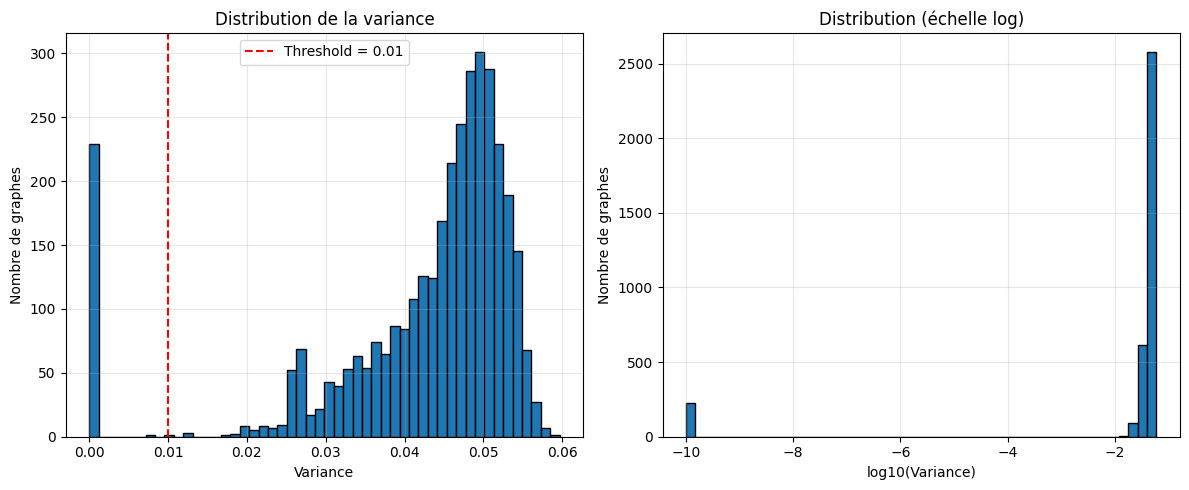


✓ Distribution sauvegardée: variance_distribution.png


In [5]:
def compute_graph_variance(G, feature_key='features_hybrid'):
    """
    Calcule la variance moyenne des features dans un graphe.
    Si tous les nœuds ont les mêmes features → variance ≈ 0
    """
    if G.number_of_nodes() < 2:
        return 0.0
    
    node_features = []
    for node in G.nodes():
        features = G.nodes[node].get(feature_key, None)
        if features is not None:
            node_features.append(features)
    
    if len(node_features) < 2:
        return 0.0
    
    node_features = np.array(node_features)
    
    # Variance moyenne par dimension
    feature_std = node_features.std(axis=0).mean()
    
    return feature_std

# Calculer variance pour chaque graphe
print(" Calcul de la variance par graphe...")
variances = []
for G in tqdm(df['graph_with_hybrid'], desc="Computing variance"):
    var = compute_graph_variance(G)
    variances.append(var)

df['graph_variance'] = variances

# Stats
print(f"\nStatistiques de variance par graphe:")
print(df['graph_variance'].describe())

# Visualiser distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['graph_variance'], bins=50, edgecolor='black')
plt.axvline(0.01, color='red', linestyle='--', label='Threshold = 0.01')
plt.xlabel('Variance')
plt.ylabel('Nombre de graphes')
plt.title('Distribution de la variance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(np.log10(df['graph_variance'] + 1e-10), bins=50, edgecolor='black')
plt.xlabel('log10(Variance)')
plt.ylabel('Nombre de graphes')
plt.title('Distribution (échelle log)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('variance_distribution.png', dpi=150)
plt.show()

print("\n✓ Distribution sauvegardée: variance_distribution.png")

In [6]:
# Filtrer les graphes avec variance trop faible
MIN_VARIANCE = 0.01

print(f"Filtrage des graphes avec variance < {MIN_VARIANCE}...")

df_clean = df[df['graph_variance'] >= MIN_VARIANCE].copy()
df_clean = df_clean.reset_index(drop=True)

print(f"\n✓ Filtrage terminé:")
print(f"  Avant: {len(df)} graphes")
print(f"  Après: {len(df_clean)} graphes")
print(f"  Supprimés: {len(df) - len(df_clean)} ({100*(len(df)-len(df_clean))/len(df):.1f}%)")

Filtrage des graphes avec variance < 0.01...

✓ Filtrage terminé:
  Avant: 3524 graphes
  Après: 3294 graphes
  Supprimés: 230 (6.5%)


## 4. Sauvegarde du dataset nettoyé

In [7]:
# Sauvegarder
with open('mermaid_graphs_vectorized_clean.pkl', 'wb') as f:
    pickle.dump(df_clean, f)

print(f"✓ Dataset nettoyé sauvegardé: mermaid_graphs_vectorized_clean.pkl")
print(f"  Graphes: {len(df_clean)}")
print(f"  Dimensions features: {new_dim}")
print(f"  Variance minimale: {MIN_VARIANCE}")

✓ Dataset nettoyé sauvegardé: mermaid_graphs_vectorized_clean.pkl
  Graphes: 3294
  Dimensions features: 387
  Variance minimale: 0.01


## 5. Résumé

In [ ]:
print("\n" + "="*60)
print("RÉSUMÉ DU NETTOYAGE")
print("="*60)

print(f"\n Dimensions constantes supprimées: {len(constant_dims)}")
print(f"   Dimensions finales: {new_dim}")

print(f"\n Graphes filtrés:")
print(f"   Total initial: {len(df)}")
print(f"   Graphes valides: {len(df_clean)}")
print(f"   Taux de rétention: {100*len(df_clean)/len(df):.1f}%")

print(f"\n Statistiques finales:")
print(df_clean[['num_nodes', 'num_edges', 'graph_variance']].describe())

print(f"\n Fichier généré:")
print(f"   mermaid_graphs_vectorized_clean.pkl")

print(f"\n Prochaine étape:")
print(f"   Utiliser ce dataset dans GNN_VAE_Training_Fixed.ipynb")


RÉSUMÉ DU NETTOYAGE

 Dimensions constantes supprimées: 3
   Dimensions finales: 387

 Graphes filtrés:
   Total initial: 3524
   Graphes valides: 3294
   Taux de rétention: 93.5%

 Statistiques finales:
         num_nodes    num_edges  graph_variance
count  3294.000000  3294.000000     3294.000000
mean     10.121129     5.376138        0.045075
std       9.054323     6.056746        0.007812
min       2.000000     0.000000        0.010336
25%       5.000000     2.000000        0.041296
50%       7.000000     4.000000        0.047179
75%      12.000000     8.000000        0.050593
max     188.000000   102.000000        0.059668

 Fichier généré:
   mermaid_graphs_vectorized_clean.pkl

 Prochaine étape:
   Utiliser ce dataset dans GNN_VAE_Training_Fixed.ipynb


: 